# 문자 레벨 기계번역기
### 참조: [sequence-to-sequence 10분만에 이해하기](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)
### 다운로드: [프랑스-영어 병렬 코퍼스](http://www.manythings.org/anki)

## 1. 데이터 확인 및 전처리

In [1]:
import pandas as pd
lines = pd.read_csv('data/fra.txt', names=['dst', 'desc'], sep='\t')
len(lines)

170651

In [2]:
# 60,000개의 샘플만 가지고 기계 번역기를 구축
lines = lines[0:60000] # 6만개만 저장
lines.sample(5)

,dst,desc
What's the date today?,Le quantième sommes-nous ?,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
She disliked him.,Elle ne l'aimait pas.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
Go play in traffic.,Va mourir.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
Is she gone?,S'en est-elle allée ?,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
Your plan sounds great.,Ton plan semble excellent.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...


In [3]:
lines.head()

,dst,desc
Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
Hi.,Salut.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
Run!,Cours !,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
Run!,Courez !,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [4]:
lines['dst'].head()

Go.         Va !
Hi.      Salut !
Hi.       Salut.
Run!     Cours !
Run!    Courez !
Name: dst, dtype: object

In [5]:
lines['desc'].head()

Go.     CC-BY 2.0 (France) Attribution: tatoeba.org #2...
Hi.     CC-BY 2.0 (France) Attribution: tatoeba.org #5...
Hi.     CC-BY 2.0 (France) Attribution: tatoeba.org #5...
Run!    CC-BY 2.0 (France) Attribution: tatoeba.org #9...
Run!    CC-BY 2.0 (France) Attribution: tatoeba.org #9...
Name: desc, dtype: object

In [6]:
# desc 컬럼 삭제
del lines['desc']

In [7]:
# index 제거
lines = lines.reset_index()
lines.head()

,index,dst
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !


In [8]:
# 컬럼명 변경
lines.rename(columns = {'index' : 'src'}, inplace = True)
lines.head()

,src,dst
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !


In [9]:
lines.sample(5)

,src,dst
914,Take mine.,Prenez le mien.
8302,I'm so unlucky!,Quelle poisse j'ai !
31645,We're closing early.,Nous fermons tôt.
52071,Have you read that book?,As-tu lu ce livre ?
37599,We're going shopping.,Nous allons faire des courses.


In [10]:
# dst 열에 <sos>로 \t, <eos>로 \n 을 추가
lines.dst = lines.dst.apply(lambda x : '\t '+ x + ' \n')
lines.sample(5)

,src,dst
48586,She couldn't afford it.,\t Elle n'en avait pas les moyens. \n
28828,I like his attitude.,\t J'apprécie son attitude. \n
6560,Tom went pale.,\t Tom a pâli. \n
20050,She decided to go.,\t Elle a décidé d'y aller. \n
27856,He can play a flute.,\t Il sait jouer de la flûte. \n


In [11]:
# 글자 집합 생성 (단어가 아님)
src_vocab = set()
for line in lines.src: # 1줄씩 읽음
    for char in line: # 1개의 글자씩 읽음
        src_vocab.add(char)

dst_vocab = set()
for line in lines.dst:
    for char in line:
        dst_vocab.add(char)

In [12]:
src_vocab_size = len(src_vocab)+1
dst_vocab_size = len(dst_vocab)+1
print(src_vocab_size, dst_vocab_size)

79 106


In [13]:
src_vocab = sorted(list(src_vocab))
dst_vocab = sorted(list(dst_vocab))
print(src_vocab[45:75])
print(dst_vocab[45:75])

['W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w']


In [14]:
# 각 글자에 인덱스 부여
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
dst_to_index = dict([(word, i+1) for i, word in enumerate(dst_vocab)])
print(src_to_index)
print(dst_to_index)

{' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, '&': 6, "'": 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, '?': 23, 'A': 24, 'B': 25, 'C': 26, 'D': 27, 'E': 28, 'F': 29, 'G': 30, 'H': 31, 'I': 32, 'J': 33, 'K': 34, 'L': 35, 'M': 36, 'N': 37, 'O': 38, 'P': 39, 'Q': 40, 'R': 41, 'S': 42, 'T': 43, 'U': 44, 'V': 45, 'W': 46, 'X': 47, 'Y': 48, 'Z': 49, 'a': 50, 'b': 51, 'c': 52, 'd': 53, 'e': 54, 'f': 55, 'g': 56, 'h': 57, 'i': 58, 'j': 59, 'k': 60, 'l': 61, 'm': 62, 'n': 63, 'o': 64, 'p': 65, 'q': 66, 'r': 67, 's': 68, 't': 69, 'u': 70, 'v': 71, 'w': 72, 'x': 73, 'y': 74, 'z': 75, 'é': 76, '’': 77, '€': 78}
{'\t': 1, '\n': 2, ' ': 3, '!': 4, '"': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, ',': 12, '-': 13, '.': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, '?': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 34, 'I': 3

In [15]:
# 영어 데이터에 대한 정수 인코딩
encoder_input = []
for line in lines.src: #입력 데이터에서 1줄씩 문장을 읽음
    temp_X = []
    for w in line: #각 줄에서 1개씩 글자를 읽음
      temp_X.append(src_to_index[w]) # 글자를 해당되는 정수로 변환
    encoder_input.append(temp_X)
print(encoder_input[:5])

[[30, 64, 10], [31, 58, 10], [31, 58, 10], [41, 70, 63, 2], [41, 70, 63, 2]]


In [16]:
# 프랑스어 데이터에 대한 정수 인코딩
decoder_input = []
for line in lines.dst:
    temp_X = []
    for w in line:
      temp_X.append(dst_to_index[w])
    decoder_input.append(temp_X)
print(decoder_input[:5])

[[1, 3, 48, 53, 3, 4, 3, 2], [1, 3, 45, 53, 64, 73, 72, 3, 4, 3, 2], [1, 3, 45, 53, 64, 73, 72, 14, 3, 2], [1, 3, 29, 67, 73, 70, 71, 105, 4, 3, 2], [1, 3, 29, 67, 73, 70, 57, 78, 105, 4, 3, 2]]


In [17]:
# 디코더의 예측값과 비교하기 위한 실제값
# 정수 인코딩 과정에서 <sos>를 제거
decoder_target = []
for line in lines.dst:
    t=0
    temp_X = []
    for w in line:
      if t>0:
        temp_X.append(dst_to_index[w])
      t=t+1
    decoder_target.append(temp_X)
print(decoder_target[:5])

[[3, 48, 53, 3, 4, 3, 2], [3, 45, 53, 64, 73, 72, 3, 4, 3, 2], [3, 45, 53, 64, 73, 72, 14, 3, 2], [3, 29, 67, 73, 70, 71, 105, 4, 3, 2], [3, 29, 67, 73, 70, 57, 78, 105, 4, 3, 2]]


In [18]:
# 패딩을 위해서 영어 문장과 프랑스어 문장 각각에 대해서 가장 길이가 긴 샘플의 길이 확인
max_src_len = max([len(line) for line in lines.src])
max_dst_len = max([len(line) for line in lines.dst])
print(max_src_len, max_dst_len)

25 76


In [19]:
# 평균 샘플 길이
print('영어 문장의 평균 길이 : {}'.format(sum(map(len, lines.src))/len(lines.src)))
print('불어 문장의 평균 길이 : {}'.format(sum(map(len, lines.dst))/len(lines.dst)))

영어 문장의 평균 길이 : 19.4515
불어 문장의 평균 길이 : 28.501116666666668


In [20]:
# 패딩시 사용할 크기 결정
pad_src_len = 25
pad_dst_len = 76

In [21]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
encoder_input = pad_sequences(encoder_input, maxlen=pad_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=pad_dst_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=pad_dst_len, padding='post')

In [22]:
# 원-핫 인코딩
from tensorflow.keras.utils import to_categorical
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

## 2. 교사 강요(Teacher forcing)
- 훈련 과정에서는 이전 시점의 디코더 셀의 출력을 현재 시점의 디코더 셀의 입력으로 넣어주지 않고,
- 이전 시점의 실제값을 현재 시점의 디코더 셀의 입력값으로 하는 방법을 사용
- RNN의 모든 시점에 대해서 이전 시점의 예측값 대신 실제값을 입력으로 주는 방법을 교사 강요라고 함

## 3. seq2seq 기계 번역기 훈련시키기

In [23]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

In [24]:
encoder_inputs = Input(shape=(None, src_vocab_size), name='Encoder_Input')
encoder_lstm = LSTM(units=256, return_state=True, name='Encoder_LSTM')
# 인코더의 내부 상태를 디코더로 넘겨주어야 하기 때문에 return_state=True로 설정
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
# encoder_outputs도 같이 리턴받기는 했지만 여기서는 필요없으므로 이 값은 버림.
encoder_states = [state_h, state_c]
# LSTM은 바닐라 RNN과는 달리 상태가 두 개. 바로 은닉 상태와 셀 상태.
# 이겻이 컨텍스트 벡터

In [25]:
decoder_inputs = Input(shape=(None, dst_vocab_size), name='Decoder_Input')
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True, name='Decoder_LSTM')
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state=encoder_states)
# 디코더의 첫 상태를 인코더의 은닉 상태, 셀 상태로 합니다.

In [26]:
decoder_softmax_layer = Dense(dst_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 79)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 106)]  0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 344064      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  371712      input_2[0][0]                    
                                                                 lstm[0][1]                   

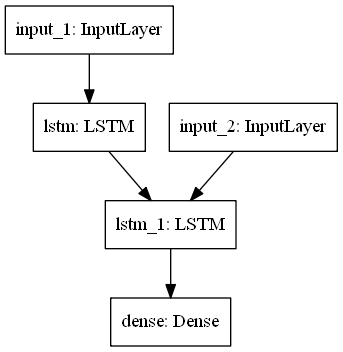

In [29]:
from tensorflow.keras.utils import plot_model
plot_model(model, 'image/seq2seq.png')

In [28]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
modelpath = "model/seq2seq-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [31]:
model.fit(x=[encoder_input, decoder_input], y=decoder_target,
          batch_size=64, epochs=50, validation_split=0.2,
          callbacks=[checkpointer, early_stopping_callback])

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
47936/48000 [============================>.] - ETA: 0s - loss: 0.7609
Epoch 00001: val_loss improved from inf to 0.69108, saving model to model/seq2seq-01-0.6911.hdf5
48000/48000 [==============================] - 96s 2ms/sample - loss: 0.7606 - val_loss: 0.6911
Epoch 2/50
47936/48000 [============================>.] - ETA: 0s - loss: 0.4789
Epoch 00002: val_loss improved from 0.69108 to 0.56103, saving model to model/seq2seq-02-0.5610.hdf5
48000/48000 [==============================] - 107s 2ms/sample - loss: 0.4788 - val_loss: 0.5610
Epoch 3/50
47936/48000 [============================>.] - ETA: 0s - loss: 0.4028
Epoch 00003: val_loss improved from 0.56103 to 0.50355, saving model to model/seq2seq-03-0.5036.hdf5
48000/48000 [==============================] - 97s 2ms/sample - loss: 0.4028 - val_loss: 0.5036
Epoch 4/50
47936/48000 [============================>.] - ETA: 0s - loss: 0.3586
Epoch 00004: val_loss improved from 0.